# Twitter Data Extraction
**Using Tweepy module for Python**    
For this assignment, we conduct a data extraction and analysis of the tweets on the current jailing of the activist Safoora Zargar, where everyone is demanding her release due to her pregnancy and dangers to her life due to the ongoing pandemic and her unsafe conditions that require medical attention.  
Reference Articles:  
https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061  
https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf

In [14]:
import tweepy
import json
import pandas as pd
import string
import os
import json
import re
import numpy as np
from textblob import TextBlob
import os
import time
import nltk
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['https','www','.com','com'])
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
#Twitter credentials
consumer_key = '#############'
consumer_secret = '##########'
access_key= '#########'
access_secret = '#########'

## Pass your credentials to the Tweepy API to gain access to data on twitter

In [3]:
# Pass twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

## Extracting Data
*Data is extracted by searching for a list of hashtags(sear_words).  
  
*Tweepy has an upper limit on the number of posts that can be extracted in a given timeframe(approximately 2500 posts per 15 minutes)    
  
*Data is therefore extracted in segments. Approximately 2000 tweets are extracted in one run and then a 7.5 minutes sleep time is implemented in the function

## Analyzing Data subjectivity and Polarity
We use TextBlob module to get an approximate idea of the subjectivity and polarity of tweets in a general basis.

In [38]:
def scraptweets(search_words,date_since,numTweets,numRuns):
    db_tweets=pd.DataFrame(columns=['username','acctdesc','location','following',
                                    'followers','totaltweets','usercreatedts','tweetcreatedts','retweetcount','text','hashtags',
                                   'polarity'])
    master_dict={'username':[],'acctdesc':[],'location':[],'following':[],
                                    'followers':[],'totaltweets':[],'usercreatedts':[],
                 'tweetcreatedts':[],'retweetcount':[],'text':[],'hashtags':[],
                                   'polarity':[],"subjectivity":[]}
    program_start=time.time()
    for i in range(0,numRuns):
        start_run=time.time()
        print("inside run number",i)
        tweets=tweepy.Cursor(api.search,q=search_words,lang="en",since=date_since,tweet_mode='extended').items(numTweets)
        print("tweets extracted")
        #store the tweets into a python list
        tweet_list=[tweet for tweet in tweets]
        noTweets=0
        for tweet in tweet_list:
            username=tweet.user.screen_name
            acctdesc=tweet.user.description
            location=tweet.user.location
            following=tweet.user.friends_count
            followers=tweet.user.followers_count
            totaltweets=tweet.user.statuses_count
            usercreatedts=tweet.user.created_at
            tweetcreatedts=tweet.created_at
            retweetcount=tweet.retweet_count
            hashtags=tweet.entities['hashtags']
            try:
                text=tweet.retweeted_status.full_text
            except AttributeError:
                text=tweet.full_text
            clean_text=clean_tweets(text)
            blob=TextBlob(clean_text)
            Sentiment=blob.sentiment
            polarity=Sentiment.polarity
            subjectivity=Sentiment.subjectivity
            tweet_dict={'username':username,'acctdesc':acctdesc,'location':location,'following':following,
                                    'followers':followers,'totaltweets':totaltweets,'usercreatedts':usercreatedts,
                 'tweetcreatedts':tweetcreatedts,'retweetcount':retweetcount,'text':clean_text,'hashtags':hashtags,
                                   'polarity':polarity,"subjectivity":subjectivity}
            for key in master_dict.keys():
                master_dict[key].append(tweet_dict[key])
            noTweets+=1
        end_run=time.time()
        duration_run=round((end_run-start_run)/60,2)
        print("no. of tweets scraped for run {} is {}".format(i+1,noTweets))
        print("time taken for {} run to complete is {} mins".format(i+1,duration_run))
        time.sleep(450)
    return master_dict

In [39]:
search_words="#SafooraZarfar OR #safoorazargar OR #ReleaseSafooraZargar OR #pregnant OR #ReleaseSafooraZargar"
date_since="2020-6-06"
numTweets=2500
numRuns=4

In [44]:
second_dict=scraptweets(search_words,date_since,1500,numRuns)

inside run number 0
tweets extracted
no. of tweets scraped for run 1 is 1500
time taken for 1 run to complete is 2.22 mins
inside run number 1
tweets extracted
no. of tweets scraped for run 2 is 1500
time taken for 2 run to complete is 2.34 mins
inside run number 2
tweets extracted
no. of tweets scraped for run 3 is 1500
time taken for 3 run to complete is 2.43 mins
inside run number 3
tweets extracted
no. of tweets scraped for run 4 is 1500
time taken for 4 run to complete is 2.32 mins


In [41]:
final_df=pd.DataFrame(final_dict)

## Data Preprocessing
### Cleaning the Text Data of the tweets
Tweets are cleaned by removing their punctuations, non ASCII characters and removing stop words(extracted from NLTK) from the tweets to extract meaningful words.

### Emoji Encodings are compiled into a set to classify the emojis and possibly extract sentiments out of the same.

In [3]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
emoticons = emoticons_happy.union(emoticons_sad)

In [26]:
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
#after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
#replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
#remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
#filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
#looping through conditions
    for w in word_tokens:
#check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)return tweet

In [42]:
final_df

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,polarity,subjectivity
0,DineshP01601197,राहुल गांधी आप अकेले भी बच जाएं पार्टी में तो ...,India,705,305,18793,2018-04-05 09:07:25,2020-06-12 13:24:22,146,Who Honest journalist Males ReleaseSafooraZargar,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.600000,0.900000
1,Pinaka78,JAI HIND. Indian First. RT/Likes may or may no...,RAS AL KHAIMAH,580,386,13685,2019-11-26 14:29:38,2020-06-12 13:24:16,223,Cute Also keep gainfully occupied SafooraZarga...,"[{'text': 'SafooraZargar', 'indices': [62, 76]}]",0.333333,0.666667
2,Shyamalgangul14,https://t.co/htGXH4zxcF from Calcutta University.,"24 Pgs. Bengal, India.",104,114,9031,2018-12-29 18:37:17,2020-06-12 13:24:06,146,Who Honest journalist Males ReleaseSafooraZargar,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.600000,0.900000
3,MukarramRuhul,चले थे हलवा खाने मुंह ही जल गया,"Katihar, India",94,16,271,2019-01-23 09:03:11,2020-06-12 13:23:51,6,ReleaseSafooraZargar ReleaseSafooraZargar She ...,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.233333,0.562963
4,amir581498,sach ki hamesha jeet hoti hai. likes & RTs do ...,,778,168,3650,2009-09-05 04:50:33,2020-06-12 13:23:33,0,RELEASE SAFOORA ZARGAR That 's 's tweet Releas...,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,JPThailand2,"मुसलमान भाजपा का शिकार नहीं हैं, बल्कि चारा है...",Thailand,4894,2085,3098,2018-10-25 09:08:58,2020-06-12 11:47:43,155,Who Honest journalist Males ReleaseSafooraZargar,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.600000,0.900000
3996,aitzazahmad22,,,193,37,285,2020-02-10 19:49:47,2020-06-12 11:47:06,1,Safoora Zargar released protesting crime India...,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.000000,0.000000
3997,salimkasmani,SUBHANALLAHI WA BIHAMDIHI SUBHANALLAHIL- AZHEEM,Khobar KSA 🇸🇦🇵🇭🇮🇳,363,36,4573,2010-03-03 05:00:26,2020-06-12 11:46:53,0,ReleaseSafooraZargar Safoora Zargar released p...,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.000000,0.000000
3998,AbbuTalib8,,"Hyderabad, India",146,13,82,2017-05-08 16:18:41,2020-06-12 11:46:09,1,Pregnant women detained even war zones But Saf...,"[{'text': 'ReleaseSafooraZargar', 'indices': [...",0.311111,0.466667


In [43]:
final_df.to_excel('4000tweets.xlsx')

In [45]:
second_df=pd.DataFrame(second_dict)

In [47]:
second_df.to_excel("tweet_data_comp.xlsx",index=False)

# Data Preprocessing

In [4]:
data=pd.read_excel('tweet_data_comp.xlsx')


In [ ]:
#dropping columns with null values
data=data.drop(['acctdesc','location'],axis=1)

## Applying hash function to the usernames to ensure privacy of the users.

In [4]:
# applying hash function to ensure privacy of usernames
data['username']=data['username'].apply(lambda x: hash(x))

#### Second Run of text preprocessing converting everything to lower cases and removing non alphabetic characters

In [5]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    word_removed=" ".join([word.lower() for word in text.split() if word not in stop_words])
    return word_removed

In [120]:
data['clean_text']=data['text'].apply(lambda x:remove_punct(x))

In [9]:
top_tweets=data.groupby('username').count().sort_values(by='followers',ascending=False).head(50).index

In [10]:
user_array=[]
for i in top_tweets:
    user_array.append(i)

In [11]:
mean_data=data.groupby('username').mean()

### Measure of polarity of the most famous tweets 

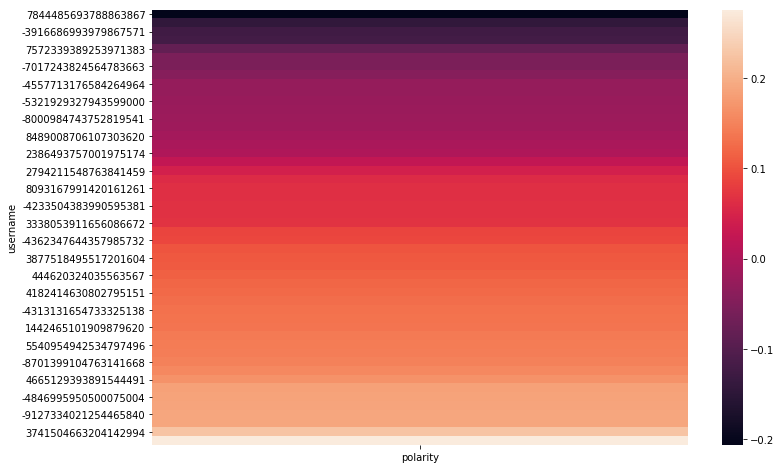

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(mean_data.loc[user_array][['polarity']].sort_values(by='polarity'))

# Analyzing the relationships between data points
The popularity of tweets on Twitter can be approximately measured by their number of retweets(or sharing of the tweetss).  
We draw a scatter plot of **Retweetcount vs Polarity** of the post to see which kind of posts are more popular.

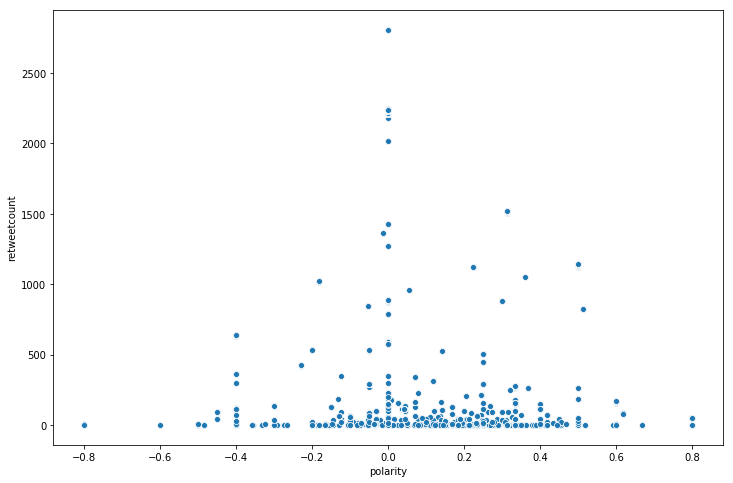

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='polarity',y='retweetcount',data=data[data['retweetcount']<6000])

## Plotting Word Counts:
We extract the most popular words and hashtags used in these tweets and plot them on a bar graph. 

In [73]:
def plot_word_count(df,column):
    CV=CountVectorizer()
    vectorized_words=CV.fit_transform(df[column])
    flair_count_df=pd.DataFrame(vectorized_words.toarray(),columns=CV.get_feature_names())
    sorted_count=pd.DataFrame(flair_count_df.sum().sort_values(ascending=False).head(30))
    plot_words([sorted_count])

def plot_words(dataframes):
    count = 0
    fig = plt.figure(figsize=(10,6))
    
    for d, dataframe in enumerate(dataframes):
        
        count += 1
        # Create the plot
        sns.barplot(
            x = 0,
            y = dataframe.index,
            data = dataframe,
            palette = "cubehelix"
        )
        plt.xlabel("Frequency")
        plt.show()

## Word Count of Original Text

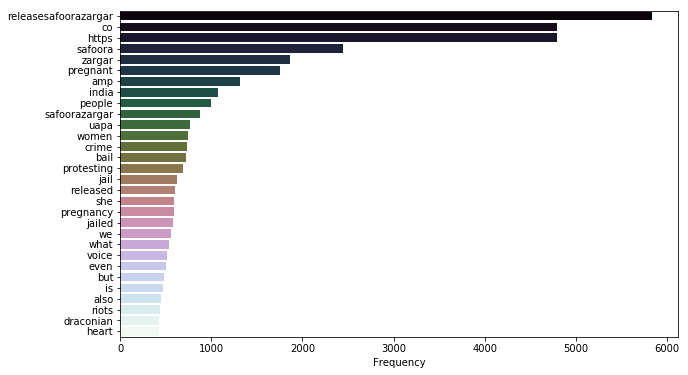

In [121]:
plot_word_count(data,'text')

## Word Count of Hashtags

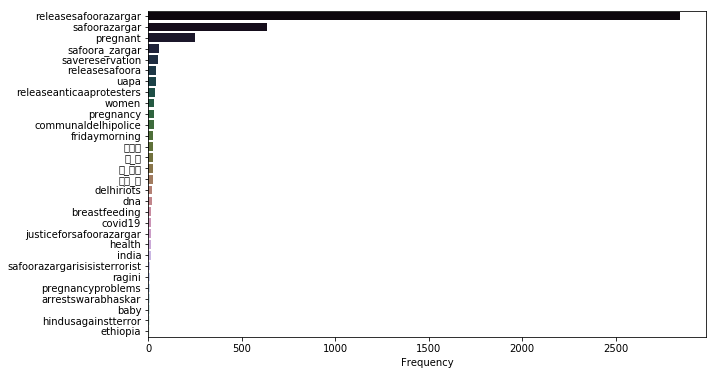

In [89]:
plot_word_count(data[data['hashtags']!='No tags'],'hashtags')

## Word Count of Processed Text Data

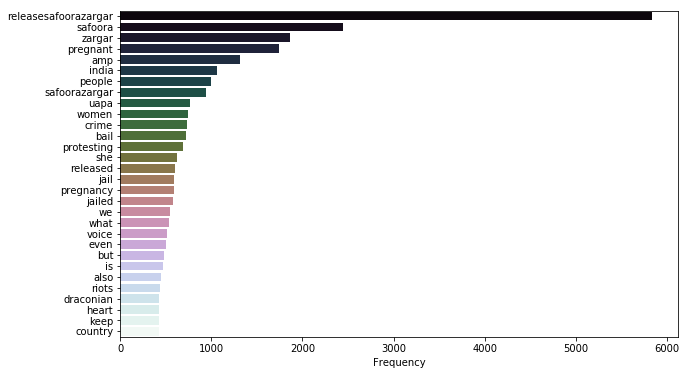

In [122]:
plot_word_count(data,'clean_text')

In [129]:
def extract_tags(x):
    if x==[]:
        return "No tags"
    else:
        x=x.replace("'","\"")
        x=json.loads(x)
        tag_list=[]
        for i in x:
            tag_list.append(i['text'])
        return " ".join(tag_list)

In [130]:
extract_tags(data['hashtags'].iloc[2])

'pregnancy pregnant gowenpregnancy gowen sketchbook sketch art'

In [131]:
data['hashtags']=data['hashtags'].apply(lambda x:extract_tags(x))

In [133]:
indexes=[]
for i in range(data.shape[0]):
    if "ebony" in data.iloc[i]['hashtags'].split():
        indexes.append(i)

In [134]:
data=data.drop(indexes)

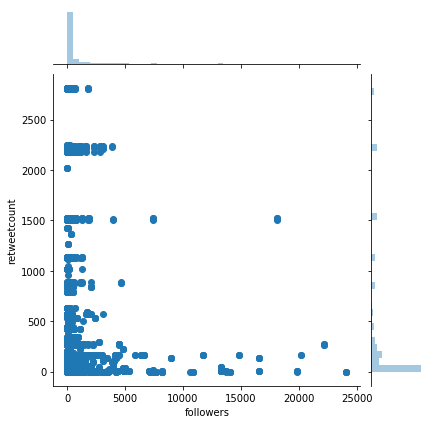

In [113]:
sns.jointplot(x='followers',y='retweetcount',data=data[(data['followers']<25000) &(data['retweetcount']<4000)])

In [135]:
data.sort_values(by='retweetcount',ascending=False).iloc[0]['text']

'Nalini LTTE assassin pregnant assassinated Rajiv Gandhi Was let pregnancy She gave birth prison RSS worker amp pregnant wife murdered Bengal one fought unborn Why fight safoorazargar pregnant'

In [136]:
data.iloc[1568]

username                                             DibaiMustakeem
following                                                       491
followers                                                        93
totaltweets                                                    1388
usercreatedts                                   2020-04-29 18:23:05
tweetcreatedts                                  2020-06-12 14:50:24
retweetcount                                                   2208
text              Safoora Zargar released protesting crime India...
hashtags                                       ReleaseSafooraZargar
polarity                                                          0
subjectivity                                                      0
clean_text        safoora zargar released protesting crime india...
Name: 1571, dtype: object

In [137]:
data.sort_values(by='retweetcount',ascending=False)

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,polarity,subjectivity,clean_text
1568,MrRahulSharrma,125,32,1126,2011-10-16 06:22:52,2020-06-12 14:51:05,11217,Nalini LTTE assassin pregnant assassinated Raj...,pregnant,0.333333,0.500000,nalini ltte assassin pregnant assassinated raj...
4756,MrRahulSharrma,125,32,1126,2011-10-16 06:22:52,2020-06-12 14:51:05,11216,Nalini LTTE assassin pregnant assassinated Raj...,pregnant,0.333333,0.500000,nalini ltte assassin pregnant assassinated raj...
3162,MrRahulSharrma,125,32,1126,2011-10-16 06:22:52,2020-06-12 14:51:05,11215,Nalini LTTE assassin pregnant assassinated Raj...,pregnant,0.333333,0.500000,nalini ltte assassin pregnant assassinated raj...
3386,azmatmalik007,26,497,868,2013-01-16 17:28:38,2020-06-12 14:15:26,8727,safoorazargar deserves better Her unborn baby ...,safoorazargar,0.500000,0.500000,safoorazargar deserves better her unborn baby ...
4980,azmatmalik007,26,497,868,2013-01-16 17:28:38,2020-06-12 14:15:26,8727,safoorazargar deserves better Her unborn baby ...,safoorazargar,0.500000,0.500000,safoorazargar deserves better her unborn baby ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Mohamme64821222,14,0,5,2020-06-03 13:41:08,2020-06-12 11:27:33,0,We stand safoora🙋‍♂️ ReleaseSafooraZargar Rele...,ReleaseSafooraZargar ReleaseSafoora,0.000000,0.000000,we stand safoora🙋‍♂️ releasesafoorazargar rele...
2921,PregmaS,241,178,61,2019-09-12 18:58:32,2020-06-12 11:28:47,0,The classic symptoms morning sickness include ...,pregnant health breastfeeding FFF ICO ACA,0.250000,0.333333,the classic symptoms morning sickness include ...
2894,Soujugada,405,346,5129,2016-09-07 17:40:08,2020-06-12 11:32:15,0,UmmatEMuslima21 DrShakirjalgaon AbdurRahman_IP...,SafooraZargar,-0.358333,0.383333,ummatemuslima drshakirjalgaon abdurrahmanips a...
2857,Sarojiniranjani,422,594,44136,2016-02-05 10:53:10,2020-06-12 11:37:05,0,Gabbar0099 IndiasMuslims Subytweets khanumarfa...,BJP ModiMadeDisaster Safoora_Zargar SafooraZar...,-0.400000,0.750000,gabbar indiasmuslims subytweets khanumarfa lad...


In [138]:
data.to_excel('tweet_data_comp.xlsx',index=False)

## Normalizing and Scaling the Data

In [22]:
Scaler=StandardScaler()
Scaler.fit(data[['followers','retweetcount']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
scaled_features=Scaler.transform(data[['followers','retweetcount']])

In [25]:
for i in range(data.shape[0]):
    data.loc[i,'scaled_followers']=scaled_features[i][0]
    data.loc[i,'scaled_rtcount']=scaled_features[i][1]

### Plotting between number of retweets and their followers, with a hue on basis of polarity

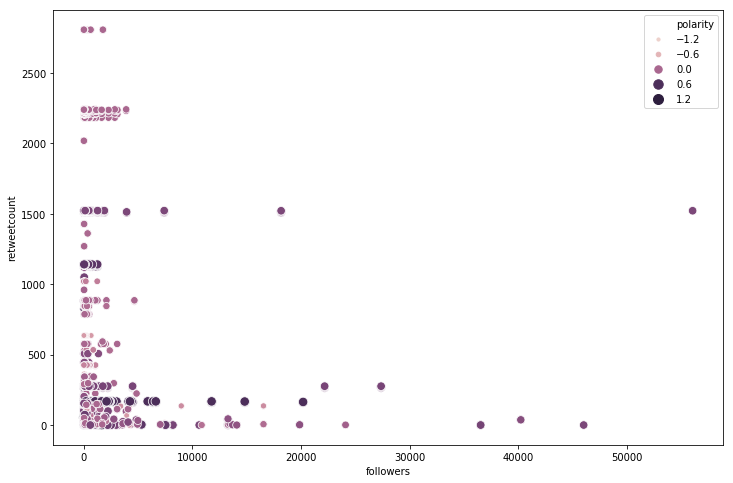

In [57]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="followers", y="retweetcount",
                     hue="polarity",size='polarity', sizes=(10,100),
                      data=data[(data['retweetcount']<4000) & (data['followers']<75000)])

In [40]:
def mediate_polarity(point):
    if point<=-.5:
        return point
    elif point>-0.5 and point<-0.4:
        
    elif point<-0.25 and point>-0.4:
        return -0.4
    elif point >-0.25 and point<0:
        return -0.1
    elif point>0 and point <0.1:
        return 0
    elif point>0.1 and point <0.3:
        return 0.2
    elif point >0.3 and point<0.5:
        return 0.4
    elif point>0.5:
        return point

In [41]:
data['mediated_polarity']=data['polarity'].apply(lambda x: mediate_polarity(x))